#### Summer of Reproducibility - noWorkflow base experiment

This notebook implements an experimental setup modeling a Credit Fraud problem.

In [1]:
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
import numpy as np
#np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=2)


from noworkflow.now.tagging.var_tagging import *

#### Reading the dataset

In [2]:
now_tag('dataset_reading')
df = pd.read_csv('dataset/creditcard.csv', encoding='utf-8')

### Feature engineering stage

Separate the features and target variable. First step in feature treatment.

In [3]:
#now_tag('feature_eng')
X = df.drop('Class', axis=1)
y = df['Class']

#### Feature engineering: Apply PCA for feature extraction.

Here we define hyperparam_def tag given that n_components argument in PCA is required

In [4]:
pca_components = now_variable('pca_components', 3)
pca = PCA(n_components=pca_components)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X)

Evaluation(id=40, checkpoint=37.786198959000004, code_component_id=1171, activation_id=37, repr=3)


#### Feature engineering: Apply random undersampling over the extracted features

Another case of feature engineering operation with hyperparameter definition. Here is random_state value for RandmUnderSampler


In [5]:
random_seed = now_variable('random_seed', 123456)
rus = RandomUnderSampler(random_state=random_seed)
X_resampled, y_resampled = rus.fit_resample(X_pca, y)

Evaluation(id=58, checkpoint=38.809740747, code_component_id=1204, activation_id=55, repr=123456)


#### Feature engineering: Spliting dataset into train and test

Here we have two hyperparameters assignments: the proportion of the test_size and the random_state. A guess here would be implement some logic to take all scalar values in hyperparam_def in cells. Not sure at the moment if there are any corner case where a hyperparameter could be vectorial or an object.

In [6]:
now_tag('feature_eng')
test_dim = now_variable('test_dim', 0.2)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=test_dim, random_state=random_seed)

Evaluation(id=80, checkpoint=39.083669804, code_component_id=1246, activation_id=74, repr=0.2)


#### Scoring: model training and transforming features into predictions
##### RandomForest

Train and evaluate Random Forest Classifier. Unsure now if adding a model_training tag would be redundant here. Scoring is enough at first sight.

In [7]:
#now_tag('scoring')
now_tag('model_training')
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

#### Evaluating: evaluating the performance of models
##### RandomForest
Computing performance metrics 

In [8]:
now_tag('evaluating')
y_pred_rf = rf.predict(X_test)

roc_rf = now_variable('roc_rf', roc_auc_score(y_test, y_pred_rf))
#roc_rf = roc_auc_score(y_test, y_pred_rf)
f1_rf = now_variable('f1_rf', f1_score(y_test, y_pred_rf))
#f1_rf = f1_score(y_test, y_pred_rf)

print("Random Forest - ROC = %f, F1 = %f" % (roc_rf, f1_rf))

Evaluation(id=124, checkpoint=39.654062131, code_component_id=1323, activation_id=110, repr=0.8138814294567237)
Evaluation(id=133, checkpoint=39.656704293000004, code_component_id=1339, activation_id=110, repr=0.8121827411167513)
Random Forest - ROC = 0.813881, F1 = 0.812183


### Output comparision


In [114]:
def tagged_comp(tag_name):
    from noworkflow.now.persistence.models.base import proxy_gen
    from noworkflow.now.persistence import relational
    import matplotlib.pyplot as plt

    access_list = list(proxy_gen(relational.session.query(StageTags.m).filter(StageTags.m.name == tag_name)))
    
    values_list = []
    for i in access_list:
        values_list.append([i.trial_id, i.trial_id[-5:],  i.name, float(i.tag_name)])
        
    return values_list

def plot_comp(tag_name = 'roc_rf'):
    import pandas as pd
    from noworkflow.now.persistence.models.base import proxy_gen
    from noworkflow.now.persistence import relational
    import matplotlib.pyplot as plt

    access_list = list(proxy_gen(relational.session.query(StageTags.m).filter(StageTags.m.name == tag_name)))
    
    values_list = []
    for i in access_list:
        values_list.append([i.trial_id, i.trial_id[-5:],  i.name, float(i.tag_name)])
    
    columns = ['trial_id', 'short_trial_id',  'tag', 'value']
    df = pd.DataFrame(values_list, columns=columns)
    
    df = df.tail(30)
    
    plt.bar(df.short_trial_id, df.value)
    plt.title(tag_name + ' values')
    plt.xticks(rotation=90)

    plt.show()

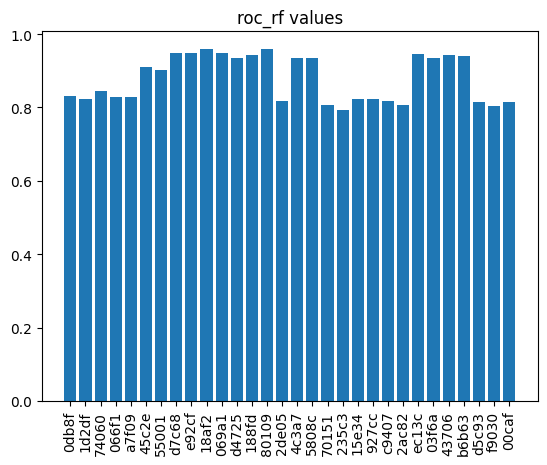

In [115]:
plot_comp('roc_rf')